## Распознавание эмоций по аудио

Датасет был найден на сайте Kaggle. Ссылка на датасет - https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess

In [3]:
import pandas as pd
import numpy as np
import os

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Audio, display

import keras
from keras.models import Sequential

import soundfile as sf

#### Загрузка датасета и проверка классов

In [6]:
data_path = 'dataset'

In [5]:
for files in os.listdir(data_path):
    print(files)

OAF_angry
OAF_disgust
OAF_Fear
OAF_happy
OAF_neutral
OAF_Pleasant_surprise
OAF_Sad
YAF_angry
YAF_disgust
YAF_fear
YAF_happy
YAF_neutral
YAF_pleasant_surprised
YAF_sad


#### Распределение количества данных внутри каждого класса

In [12]:
data_amount_info = {}
data_duration_info = {}

for emotion in os.listdir(data_path):
    print(emotion)
    emotion_path = os.path.join(data_path, files)
    for file in os.listdir(emotion_path):
        file_path = os.path.join(emotion_path, file)
        if file.endswith(".wav"):
            duration = librosa.get_duration(path=file_path)  # продолжительность файла
            data_duration_info[emotion] = data_duration_info.get(emotion, 0) + duration  # добавляем продолжительность к нужной эмоции

            data_amount_info[emotion] = data_amount_info.get(emotion, 0) + 1  # считаем количество файлов
        else:
            print('Найден файл с некорректным разрешением')

OAF_angry
OAF_disgust
OAF_Fear
OAF_happy
OAF_neutral
OAF_Pleasant_surprise
OAF_Sad
YAF_angry
YAF_disgust
YAF_fear
YAF_happy
YAF_neutral
YAF_pleasant_surprised
YAF_sad


Заметим, что среди классов есть повторяющиеся. Как и упоминалось в описании датасета, разница в авторе озвучки. 2 женщины записаны под своими инициалами. Для обучения модели нет небходимости в таком разделении, поэтому в дальнейшем будет перераспределение классов.

In [13]:
# средняя продолжительность звукового фрагмента данных
for emotion in data_duration_info.keys():
    data_duration_info[emotion] /= data_amount_info[emotion]

In [14]:
data_amount_info

{'OAF_angry': 200,
 'OAF_disgust': 200,
 'OAF_Fear': 200,
 'OAF_happy': 200,
 'OAF_neutral': 200,
 'OAF_Pleasant_surprise': 200,
 'OAF_Sad': 200,
 'YAF_angry': 200,
 'YAF_disgust': 200,
 'YAF_fear': 200,
 'YAF_happy': 200,
 'YAF_neutral': 200,
 'YAF_pleasant_surprised': 200,
 'YAF_sad': 200}

In [15]:
data_duration_info

{'OAF_angry': 2.2683728598345207,
 'OAF_disgust': 2.2683728598345207,
 'OAF_Fear': 2.2683728598345207,
 'OAF_happy': 2.2683728598345207,
 'OAF_neutral': 2.2683728598345207,
 'OAF_Pleasant_surprise': 2.2683728598345207,
 'OAF_Sad': 2.2683728598345207,
 'YAF_angry': 2.2683728598345207,
 'YAF_disgust': 2.2683728598345207,
 'YAF_fear': 2.2683728598345207,
 'YAF_happy': 2.2683728598345207,
 'YAF_neutral': 2.2683728598345207,
 'YAF_pleasant_surprised': 2.2683728598345207,
 'YAF_sad': 2.2683728598345207}

В датасете одинаковое количество данных на каждую эмоцию и одинаковая средняя длина записи

#### Демонстрация случайных записей

In [16]:
for emotion in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion)
    file = fr'{emotion_path}\{np.random.choice(os.listdir(emotion_path))}'
    file_path = os.path.join(emotion_path, file)
    print(emotion)
    display(Audio(file_path))

OAF_angry


OAF_disgust


OAF_Fear


OAF_happy


OAF_neutral


OAF_Pleasant_surprise


OAF_Sad


YAF_angry


YAF_disgust


YAF_fear


YAF_happy


YAF_neutral


YAF_pleasant_surprised


YAF_sad


Проанализировав записи, становится понятно, что разница между одинаковыми классами в том, что их произносят разные люди. Соответственно, их можно поместить в один класс в будущем.
Вывод, полученный после прослушивания, подтверждает описание датасета

#### Построение спектрограмм и waveplot случайных записей

In [17]:
def create_waveplot(data, sr, e, ax=None):
    if ax is not None:
        plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    return librosa.display.waveshow(data, sr=sr, ax=ax, color='#5EE8AC')

def create_spectrogram(data, sr, e, ax=None, **kwargs):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    if ax is not None:
        plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    return librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax, cmap='Accent', **kwargs)

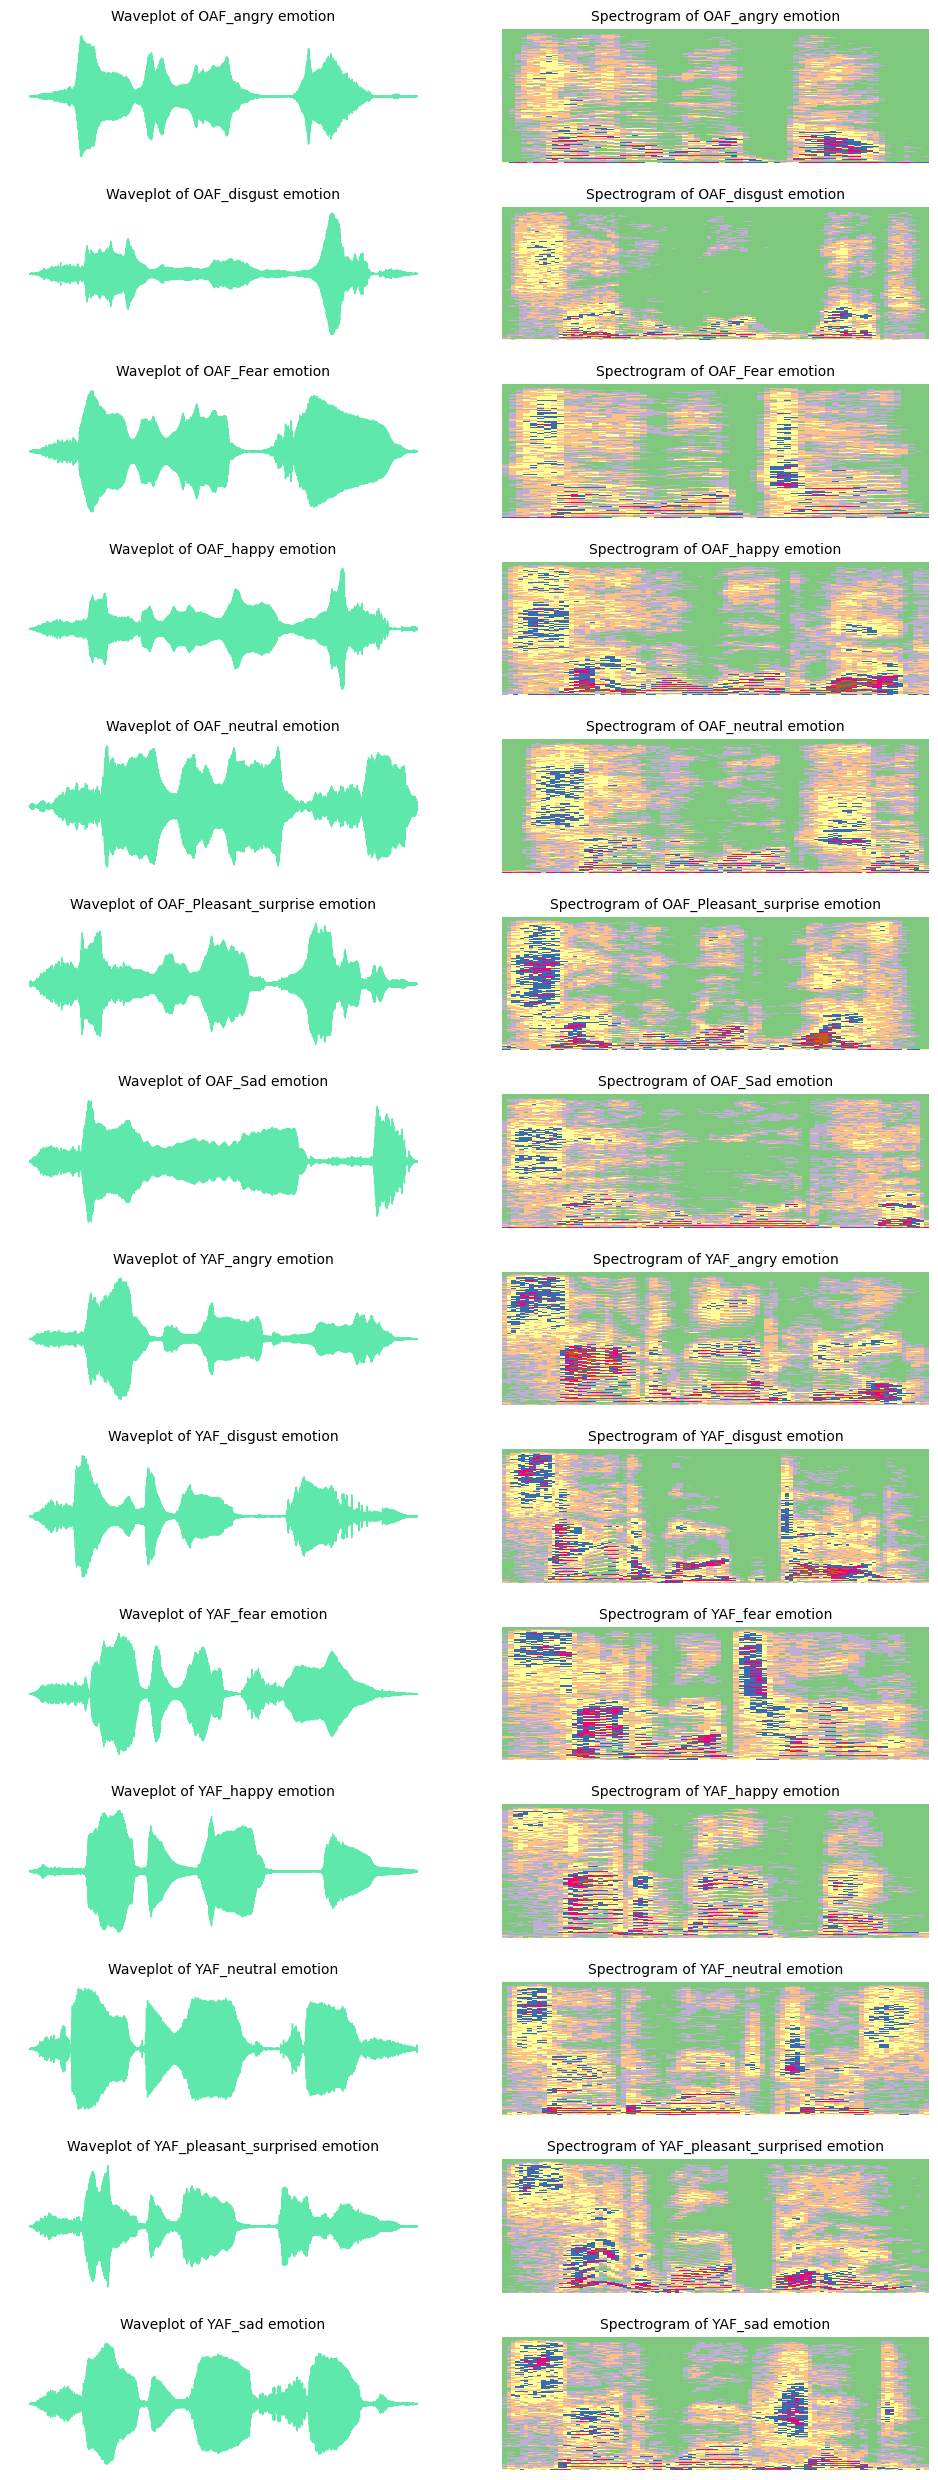

In [18]:
fig, axes = plt.subplots(len(data_amount_info), 2)
fig.set_size_inches(10, 25)
fig.tight_layout()

for emotion, ax in zip(os.listdir(data_path), axes):
    emotion_path = os.path.join(data_path, emotion)
    file = fr'{emotion_path}\{np.random.choice(os.listdir(emotion_path))}'  # берем случайный файл из датасета по каждой эмоции
    file_path = os.path.join(emotion_path, file)
    data, sr = librosa.load(file_path)
    create_waveplot(data, sr, emotion, ax=ax[0])
    create_spectrogram(data, sr, emotion, ax=ax[1])
    ax[0].set_title(f'Waveplot of {emotion} emotion', size=10)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[1].set_title(f'Spectrogram of {emotion} emotion', size=10)

#### Объединение классов

Перенос и объединение классов, без изменения и переноса изначального датасета

In [9]:
def create_dataset(path_from, path_to):
    flag=False
    if not os.path.exists(path_to):  # создание пуи к датасету, если его не было
        os.mkdir(path_to)
    for emotion in os.listdir(path_from):
        emotion_name = emotion[4:] if emotion != 'YAF_pleasant_surprised' else 'pleasant_surprise'  # ошибка в названии папки в датасете => исправление
        print(emotion)
        final_path = f'{path_to}/{emotion_name.lower()}'
        if not os.path.exists(final_path):  # создание папки с эмоцией
            k = 0  # для отсчета файлов
            os.mkdir(final_path)
        else:
            flag=True
        if flag: k = 200  # для отсчета файлов
        emotion_path = os.path.join(data_path, emotion)
        for file in os.listdir(emotion_path):
            k += 1

            file_path_from = os.path.join(emotion_path, file)
            file_path_to = os.path.join(final_path, f'{emotion_name}_{k}.wav')
            audio_data, sampling_rate = librosa.load(file_path_from)
            sf.write(file_path_to, audio_data, sampling_rate)

In [10]:
create_dataset(data_path, "prepared_dataset")

OAF_angry
OAF_disgust
OAF_Fear
OAF_happy
OAF_neutral
OAF_Pleasant_surprise
OAF_Sad
YAF_angry
YAF_disgust
YAF_fear
YAF_happy
YAF_neutral
YAF_pleasant_surprised
YAF_sad


Были объединены данные с одинаковой эмоцией, но произносимые разными людьми. Это было нужно сделать, чтобы не учить нейросеть распознавать разные типы голоса, как главную цель классификации. Ее задача - распознавание эмоции.

In [11]:
data_path_prep = "prepared_dataset"

Узнаем частоту записей, чтобы приводить все к ней при дальнейшем использовании

In [26]:
emotion = np.random.choice(os.listdir(data_path_prep))
file = np.random.choice(os.listdir(os.path.join(data_path_prep, emotion)))
path = fr'{data_path_prep}\{emotion}\{file}'

In [27]:
data, sr = librosa.load(path)

In [28]:
sr  # sampling rate

22050

### `Обучим 2 варианта нейросети`
- предобработка данных через MFCC
- предобработка данных через STFT

`1. Что это такое?`

##### **MFCC (Mel Frequency Cepstral Coefficients)**:
- **Расшифровка**: Коэффициенты кепстра мел-шкалы частот.
- **MFCC** - это способ представления звука, который приближен к тому, как его слышит человек. Этот метод используется, чтобы выделить важные частоты для машинного анализа речи. MFCC преобразует звуковые данные таким образом, что низкие частоты, на которые мы более чувствительны, получают больше внимания.

##### **STFT (Short-Time Fourier Transform)**:
- **Расшифровка**: Коротковременное преобразование Фурье.
- **STFT** - это метод, который разбивает длинный звуковой сигнал на маленькие отрезки (окна) и анализирует частоты в каждом из них. Он помогает отслеживать, как частоты меняются во времени.

#### MFCC

#### Подготовка к обучению

In [29]:
def feature_extractor(file_name):
    """Обработка звукового сигнала через метод MFCC"""
    audio_data, sampling_rate = librosa.load(file_name)
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
    scaled_mfcc_features = np.mean(mfcc_features.T, axis=0)
    return scaled_mfcc_features

In [30]:
extracted_features = []

for emotion in os.listdir(data_path_prep):
    emotion_path = os.path.join(data_path_prep, emotion)
    for file in os.listdir(emotion_path):
        file_path = os.path.join(emotion_path, file)
        data = feature_extractor(file_path)
        extracted_features.append([data, emotion])

In [31]:
data = pd.DataFrame(extracted_features, columns=['data', 'label'])  # датасет с обработанными данными

In [32]:
data.sample(5)

,data,label
389,"[-390.21344, 60.074726, 18.286139, -0.7348799,...",angry
405,"[-445.15826, 103.62106, 27.280426, -5.6841564,...",disgust
1764,"[-377.77267, 42.745033, 0.6514506, 37.50292, 3...",neutral
1093,"[-291.61557, 7.3631425, -2.3518956, 11.374502,...",fear
315,"[-374.97095, 38.815823, 11.0193405, 16.113024,...",angry


In [33]:
data.shape

(2800, 2)

In [34]:
num_labels = data.label.nunique()
num_labels

7

In [35]:
X = np.array(data['data'].to_list())
y = np.array(data['label'].to_list())

In [36]:
X.shape

(2800, 40)

In [37]:
le = OneHotEncoder(sparse_output=False)
y = le.fit_transform(y.reshape(-1, 1))
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [38]:
y.shape, X.shape

((2800, 7), (2800, 40))

In [39]:
import joblib
joblib.dump(le, 'OHE_mfcc.joblib')

['OHE_mfcc.joblib']

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [41]:
x_val, y_val = x_test[:len(x_test)//2], y_test[:len(y_test)//2]
x_test, y_test = x_test[len(x_test)//2:], y_test[len(y_test)//2:]

#### Создание архитектуры НС и обучение

In [42]:
model_mfcc = Sequential()

model_mfcc.add(layers.Input(shape=(40,)))

# первый слой
model_mfcc.add(layers.Dense(100))
model_mfcc.add(layers.Activation('relu'))
model_mfcc.add(layers.Dropout(0.5))

# второй слой
model_mfcc.add(layers.Dense(200))
model_mfcc.add(layers.Activation('relu'))
model_mfcc.add(layers.Dropout(0.5))

# третий слой
model_mfcc.add(layers.Dense(200))
model_mfcc.add(layers.Activation('relu'))
model_mfcc.add(layers.Dropout(0.5))

# финальный слой
model_mfcc.add(layers.Dense(num_labels))
model_mfcc.add(layers.Activation('softmax'))

In [43]:
model_mfcc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               4

In [44]:
model_mfcc.compile(optimizer='adam',
              loss='categorical_crossentropy',  # используется если классы пересекаются между собой
              metrics=['accuracy']
              )

In [45]:
epochs = 200
batch_size = 16

callbacks = keras.callbacks.EarlyStopping(monitor='loss', patience=8, min_delta=0.01, verbose=0)

In [46]:
history_mfcc = model_mfcc.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
140/140 [==============================] - 1s 2ms/step - loss: 23.6813 - accuracy: 0.1496 - val_loss: 1.7080 - val_accuracy: 0.4000
Epoch 2/200
140/140 [==============================] - 0s 915us/step - loss: 5.2926 - accuracy: 0.1817 - val_loss: 1.7135 - val_accuracy: 0.5000
Epoch 3/200
140/140 [==============================] - 0s 956us/step - loss: 2.6064 - accuracy: 0.2692 - val_loss: 1.7129 - val_accuracy: 0.4821
Epoch 4/200
140/140 [==============================] - 0s 961us/step - loss: 1.8398 - accuracy: 0.3433 - val_loss: 1.4473 - val_accuracy: 0.6214
Epoch 5/200
140/140 [==============================] - 0s 931us/step - loss: 1.4964 - accuracy: 0.4446 - val_loss: 1.1197 - val_accuracy: 0.7429
Epoch 6/200
140/140 [==============================] - 0s 907us/step - loss: 1.2555 - accuracy: 0.5192 - val_loss: 0.8980 - val_accuracy: 0.8500
Epoch 7/200
140/140 [==============================] - 0s 909us/step - loss: 1.0439 - accuracy: 0.5996 - val_loss: 0.7082 - val_acc

In [47]:
model_mfcc.save('model_mfcc.keras')

#### STFT

#### Подготовка к обучению

In [48]:
def get_spectrogram(waveform): 
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
    spectrogram = tf.abs(spectrogram)
    return spectrogram[..., tf.newaxis]

In [49]:
def get_spectrogram_dataset(dataset):
    """Применение обработки звукового сигнала ко всему датасету"""
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y),
                          num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [50]:
def squeeze(audio, labels):
    '''перевод звука в формат mono'''
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

In [51]:
training_set, validation_set = keras.utils.audio_dataset_from_directory(
    directory=data_path_prep,
    batch_size=16,
    validation_split=0.2,
    output_sequence_length=22_050,
    subset='both',
    seed=42
)

Found 2800 files belonging to 7 classes.
Using 2240 files for training.
Using 560 files for validation.


In [52]:
label_names = training_set.class_names
label_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad']

In [53]:
training_set = training_set.map(squeeze, tf.data.AUTOTUNE)
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [54]:
train_set = get_spectrogram_dataset(training_set) 
validation_set = get_spectrogram_dataset(validation_set) 
  
# разбиваем на валидационный и тестовый
val_set = validation_set.take(validation_set.cardinality() // 2) 
test_set = validation_set.skip(validation_set.cardinality() // 2)

In [55]:
input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names)

Input shape: (171, 129, 1)


In [56]:
# все размеры должны совпадать

train_set_shape = train_set.element_spec[0].shape 
val_set_shape = val_set.element_spec[0].shape 
test_set_shape = test_set.element_spec[0].shape 
  
print("Train set shape:", train_set_shape) 
print("Validation set shape:", val_set_shape) 
print("Testing set shape:", test_set_shape)

Train set shape: (None, 171, 129, 1)
Validation set shape: (None, 171, 129, 1)
Testing set shape: (None, 171, 129, 1)


#### Создание архитектуры НС и обучение

In [64]:
model_stft = tf.keras.Sequential([ 
        tf.keras.layers.Input(shape=input_shape), 

        tf.keras.layers.Resizing(64, 64), 
        tf.keras.layers.Normalization(), 
          
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(), 
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Flatten(),
          
        tf.keras.layers.Dense(num_labels, activation='softmax')
])

In [65]:
model_stft.compile( 
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'] 
)

In [66]:
model_stft.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 64, 64, 1)         3         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 61504)            

In [67]:
epochs = 20
verbose = True

monitor = 'val_loss'
min_delta = 0.01
patience = 4

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose)]

In [68]:
history_stft = model_stft.fit(
    train_set,
    validation_data=val_set,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
140/140 [==============================] - 3s 22ms/step - loss: 0.5604 - accuracy: 0.8152 - val_loss: 0.1757 - val_accuracy: 0.9449
Epoch 2/20
140/140 [==============================] - 3s 23ms/step - loss: 0.1295 - accuracy: 0.9670 - val_loss: 0.2403 - val_accuracy: 0.9081
Epoch 3/20
140/140 [==============================] - 3s 23ms/step - loss: 0.0777 - accuracy: 0.9804 - val_loss: 0.1384 - val_accuracy: 0.9743
Epoch 4/20
140/140 [==============================] - 3s 24ms/step - loss: 0.0419 - accuracy: 0.9897 - val_loss: 0.1057 - val_accuracy: 0.9779
Epoch 5/20
140/140 [==============================] - 3s 23ms/step - loss: 0.0487 - accuracy: 0.9902 - val_loss: 0.1745 - val_accuracy: 0.9596
Epoch 6/20
140/140 [==============================] - 3s 22ms/step - loss: 0.0448 - accuracy: 0.9879 - val_loss: 0.1222 - val_accuracy: 0.9779
Epoch 7/20
140/140 [==============================] - 3s 22ms/step - loss: 0.0204 - accuracy: 0.9951 - val_loss: 0.1335 - val_accuracy: 0.9779

In [69]:
model_stft.save('model_stft.keras')

In [61]:
# model = tf.keras.models.load_model('model.keras')

### Оценка обучения

In [70]:
model_stft = tf.keras.models.load_model('model_stft.keras')
model_mfcc = tf.keras.models.load_model('model_mfcc.keras')

In [71]:
model_mfcc.evaluate(x_test, y_test)

9/9 [==============================] - 0s 740us/step - loss: 0.0417 - accuracy: 0.9893


[0.04168245568871498, 0.9892857074737549]

In [72]:
model_stft.evaluate(test_set)

18/18 [==============================] - 0s 6ms/step - loss: 0.0219 - accuracy: 0.9931


[0.021851427853107452, 0.9930555820465088]

In [73]:
def full_plot_model_metrics(history):
    # разделяем данные из истории обучения на треноровочные и тестовые
    metrics = list(history.history.items())[:len(history.history.items())//2+1]
    val_metrics = list(history.history.items())[len(history.history.items())//2:]

    plt.figure(figsize=(30, 5))

    for i, metric, val_metric in zip(range(len(history.history.keys())), metrics, val_metrics):
        plt.subplot(1, len(history.history.items()), i+1)
        plt.plot(range(1, len(metric[1])+1), metric[1], c='blue', label='training')
        plt.plot(range(1, len(val_metric[1])+1), val_metric[1], c='red', label='validation')
        plt.legend(loc='upper right')
        plt.title(metric[0].upper())
        plt.xlabel('epochs')
        plt.ylabel(metric[0])
        plt.tight_layout(h_pad=2, w_pad=2)
        plt.grid(True)

Для модели с обработкой MFCC

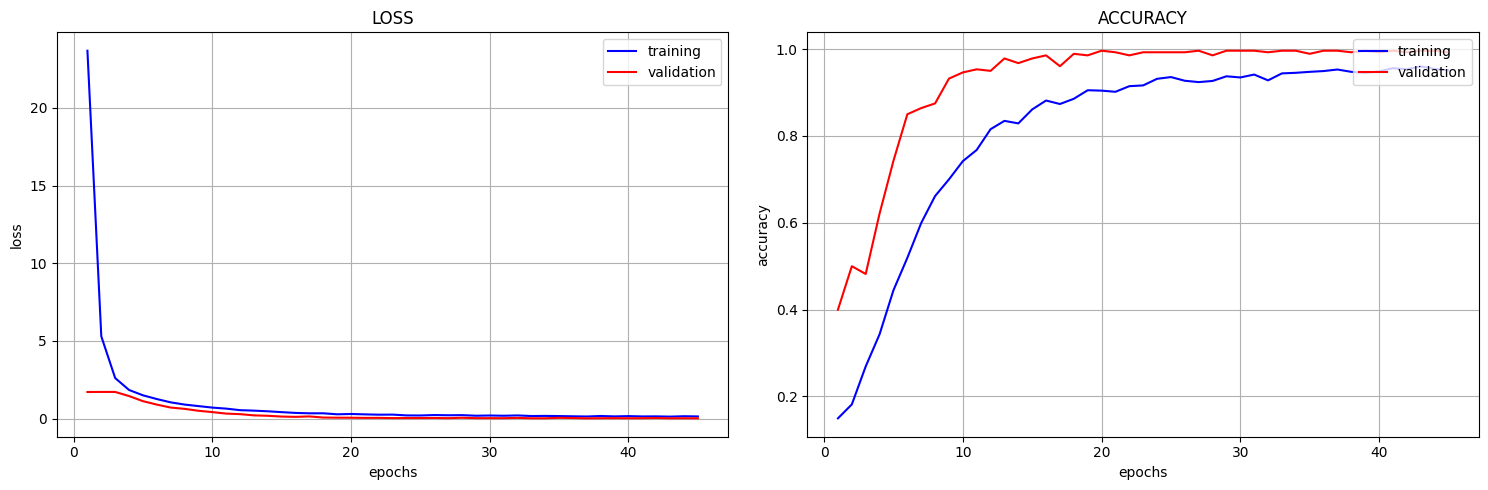

In [74]:
full_plot_model_metrics(history_mfcc)

Для модели с обработкой STFT

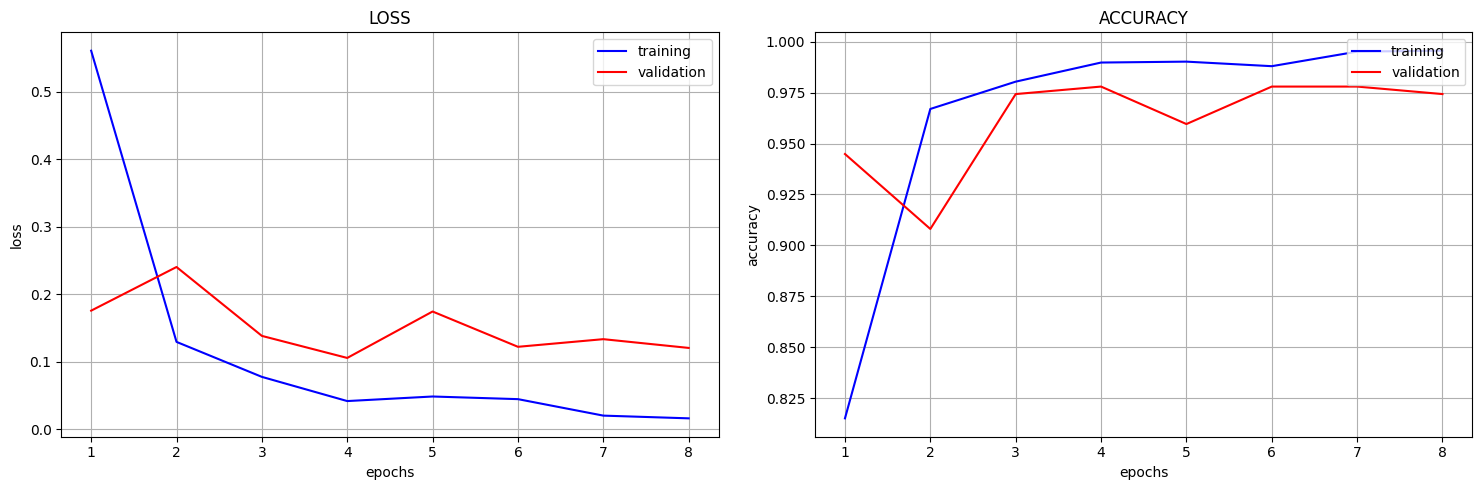

In [75]:
full_plot_model_metrics(history_stft)

Матрица путаницы

In [76]:
def prepare_predictions(pred):
    positions =  np.argmax(pred, axis=1)
    emotions =  np.array(label_names)[positions].reshape(-1, 1)
    return emotions

In [77]:
y_pred_mfcc = prepare_predictions(model_mfcc.predict(x_test))
y_pred_stft = prepare_predictions(model_stft.predict(test_set))
y_test_mfcc = prepare_predictions(y_test)

18/18 [==============================] - 0s 6ms/step


In [78]:
y_true = np.concatenate([y for x, y in test_set])
y_true = np.array(label_names)[y_true].reshape(-1, 1)

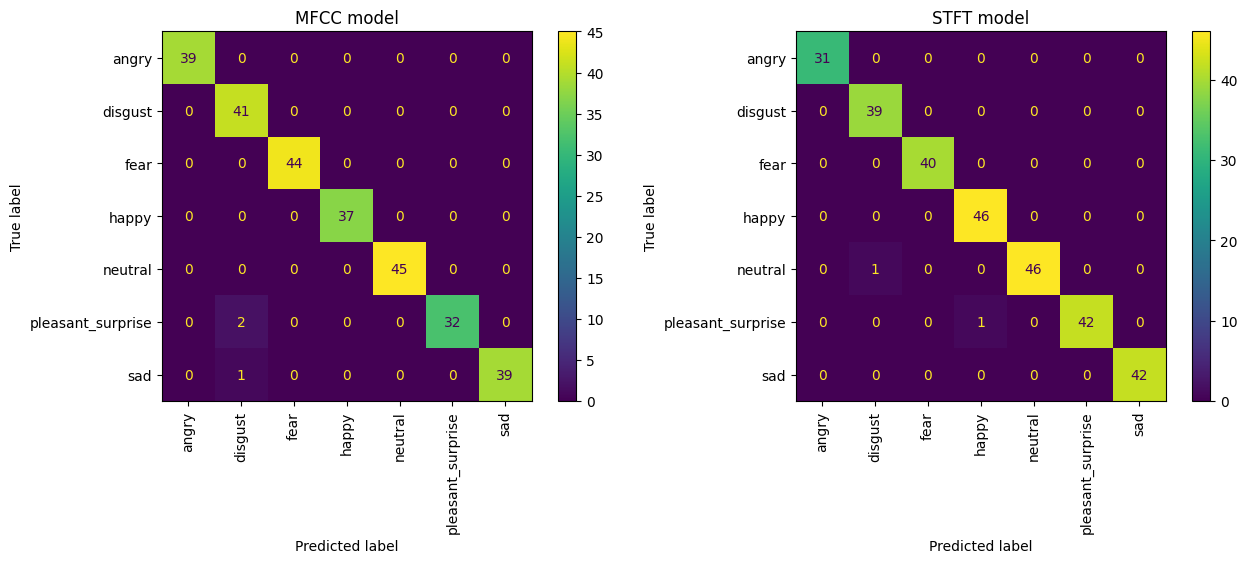

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.set_title('MFCC model')
ax2.set_title('STFT model')

ConfusionMatrixDisplay.from_predictions(y_test_mfcc, y_pred_mfcc, xticks_rotation=90, ax=ax1);
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_stft, xticks_rotation=90, ax=ax2);

Метрики после обучения

In [81]:
print(classification_report(y_test_mfcc, y_pred_mfcc))

                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00        39
          disgust       0.93      1.00      0.96        41
             fear       1.00      1.00      1.00        44
            happy       1.00      1.00      1.00        37
          neutral       1.00      1.00      1.00        45
pleasant_surprise       1.00      0.94      0.97        34
              sad       1.00      0.97      0.99        40

         accuracy                           0.99       280
        macro avg       0.99      0.99      0.99       280
     weighted avg       0.99      0.99      0.99       280



In [82]:
print(classification_report(y_true, y_pred_stft))

                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00        31
          disgust       0.97      1.00      0.99        39
             fear       1.00      1.00      1.00        40
            happy       0.98      1.00      0.99        46
          neutral       1.00      0.98      0.99        47
pleasant_surprise       1.00      0.98      0.99        43
              sad       1.00      1.00      1.00        42

         accuracy                           0.99       288
        macro avg       0.99      0.99      0.99       288
     weighted avg       0.99      0.99      0.99       288



### Вывод

Исходя из графика обучения моделей и их матриц путаницы при тесте, можно сделать вывод, что модель, обученная на STFT преобразованных данных показала себя, незначительно, но лучше.
Это подтверждает слова о том, что STFT лучше работает с шумными записями. Приведенный датасет не был сильно шумным, однако разница все равно есть. В дальшем при использовании однозначно могут быть шумы. Это стоит учитывать

Выбираю модель `model_stft`

### Тестирование

In [68]:
path = fr"C:\projects\Python\ml\DAILY_WORK\project_audio\test_files\test_4.wav"

In [74]:
data, sr = librosa.load(path)

In [75]:
sr

22050

In [78]:
data, samplerate = sf.read(path)
sf.write(f'{path[:-4]}_new.wav', data, samplerate, subtype='PCM_16')

In [80]:
Input = tf.io.read_file(f'{path[:-4]}_new.wav') 
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=22_050)
audio, labels = squeeze(x, 'yes')

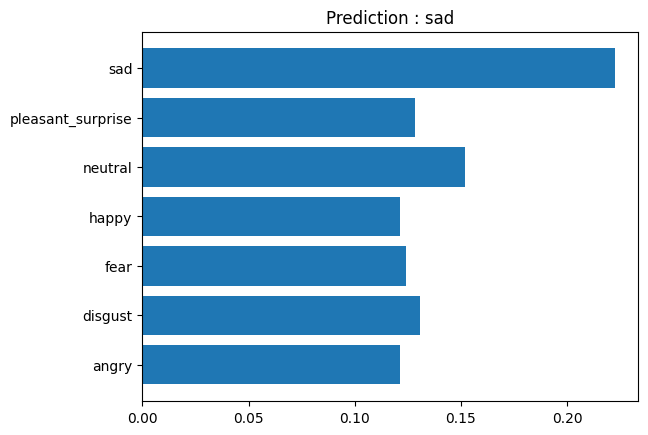

In [81]:
x = get_spectrogram(audio) 
x = tf.expand_dims(x, axis=0) 
  
prediction = model(x) 
plt.barh(label_names, tf.nn.softmax(prediction[0])) 
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()]) 
plt.show()

In [82]:
test_path = fr'C:\projects\Python\ml\DAILY_WORK\project_audio\test_files'

In [83]:
waveform = audio 
display(Audio(waveform, rate=22_050))

In [84]:
Audio(path)